# Part I: Research Question

## Research Question

What is the projected revenue for WGU Medical for Q1 2024?

## Goal

The goal of this analysis is to predict three months of revenue growth for WGU Medical with time series forecasting, specifically using autoregressive integrated moving average (ARIMA) methods. 

# Part II: Method Justification

B.  Summarize the assumptions of a time series model including stationarity and autocorrelated data.

# Part III: Data Preparation

## Exploratory Data Analysis

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the dataset using pandas
import pandas as pd

df = pd.read_csv("source/medical_time_series.csv", header='infer')
df.head(5)

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


### Null Values

In [3]:
df.isna().sum()

Day        0
Revenue    0
dtype: int64

### Add Dates

In [4]:
# add dates to dataframe

dti = pd.date_range("2021-01-01", periods=731, freq="D")
df['Date'] = dti
df = df[['Date', 'Revenue']]
df.head(5)

,Date,Revenue
0,2021-01-01,0.000000
1,2021-01-02,-0.292356
2,2021-01-03,-0.327772
3,2021-01-04,-0.339987
4,2021-01-05,-0.124888


In [5]:
# create new columns from datetime index

df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day

df = df[['Date', 'Year', 'Month', 'Day', 'Revenue']]
df.head(5)

,Date,Year,Month,Day,Revenue
0,2021-01-01,2021,1,1,0.000000
1,2021-01-02,2021,1,2,-0.292356
2,2021-01-03,2021,1,3,-0.327772
3,2021-01-04,2021,1,4,-0.339987
4,2021-01-05,2021,1,5,-0.124888


### Line Plot

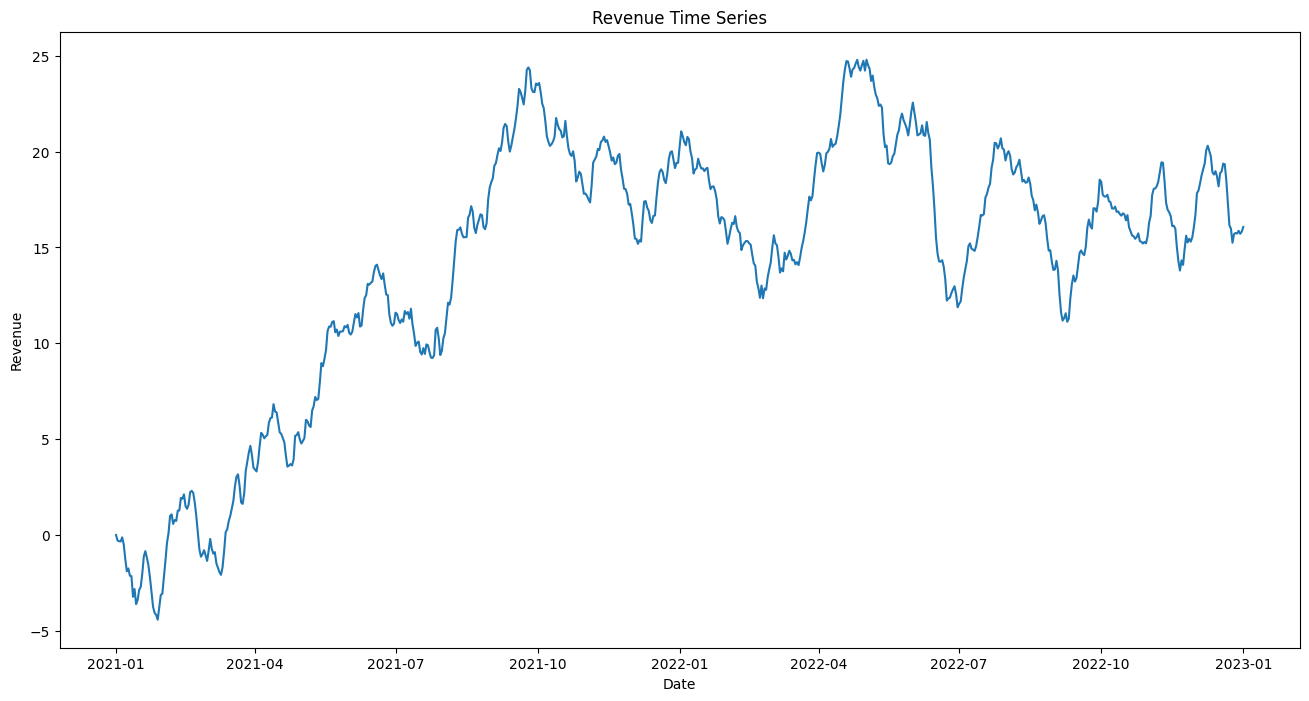

In [6]:
# plot visualizations using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,8))
sns.lineplot(x=df.Date, y=df.Revenue)
plt.title('Revenue Time Series')
plt.show()

### Box Plots by Month

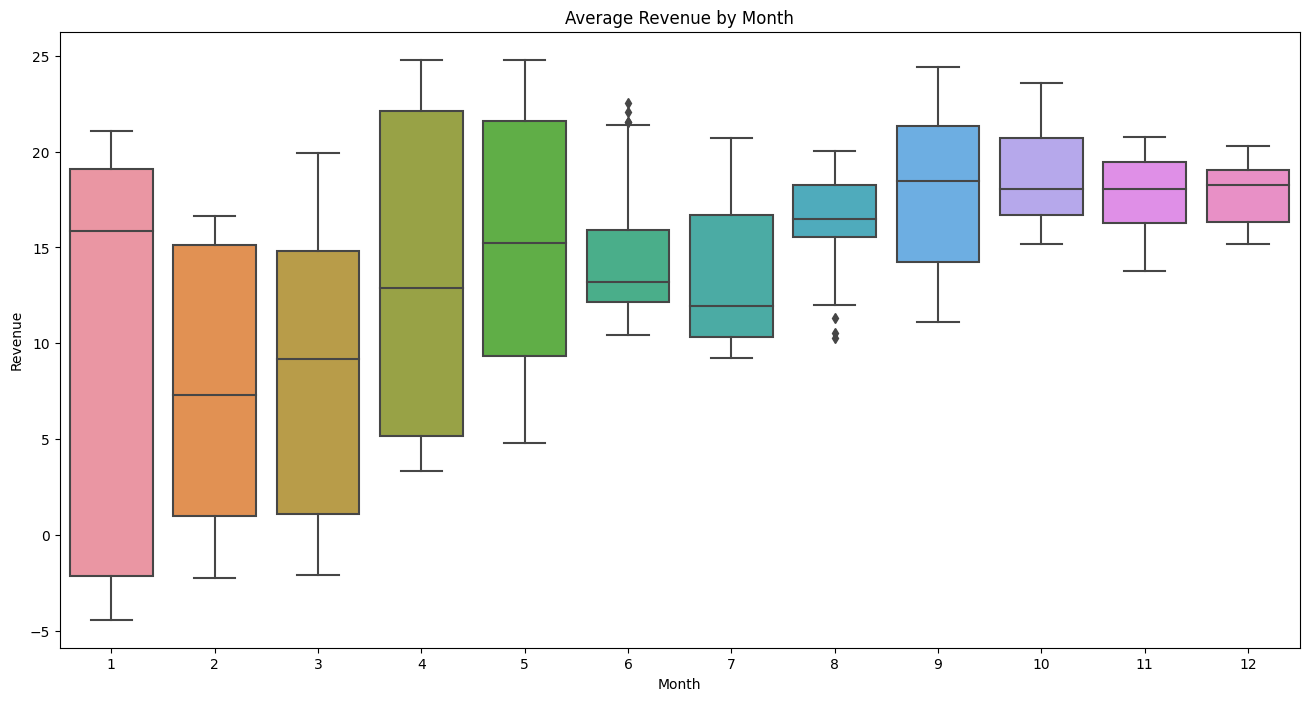

In [7]:
# boxplots by month

plt.figure(figsize=(16,8))
sns.boxplot(x = 'Month', y='Revenue', data = df)
plt.title('Average Revenue by Month')
plt.show()

### Step Formatting

The step formatting of this time series is daily and has been formatted as YYYY-MM-DD. The time series begins at 2021-01-01 and ends at 2023-01-01. In other words, the length of the time series is 2 years. No gaps exist in this time series.

## Stationarity

In [8]:
# use statsmodels to calculate stationarity
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df.Revenue, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print('ADF Statistic: %f' % adf_result[0])
print('Critical Value: %f' % adf_result[4]['5%'])
print('\np-value: %f' % adf_result[1])
print('Significance Level: 0.05')

ADF Statistic: -2.218319
Critical Value: -2.865513

p-value: 0.199664
Significance Level: 0.05


Since the ADF Statistic for this data series is more positive than the Critical Value, we fail to reject the null hypothesis, i.e., the time series is not stationary.

## Data Preparation

Dates were added to the time series in YYYY-MM-DD format, starting at 2021-01-01 and ending at 2023-01-01. To do this, a range of dates were created using the pandas.date_range() function. This range of dates was added to the time series dataframe as a new column named 'Date.'

No further data preparation steps were implemented.

## Train Test Split

In [9]:
train = df[['Date', 'Revenue']][:511]
train.set_index(train.Date, inplace=True)
train.drop(columns='Date', inplace=True)

test = df[['Date', 'Revenue']][511:]
test.set_index(test.Date, inplace=True)
test.drop(columns='Date', inplace=True)

train.to_csv('output/train.csv', index=0)
test.to_csv('output/test.csv', index=0)

# Part IV: Model Identification and Analysis

## Decomposed Time Series

In [10]:
# use statsmodels to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(train, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)

### Trend

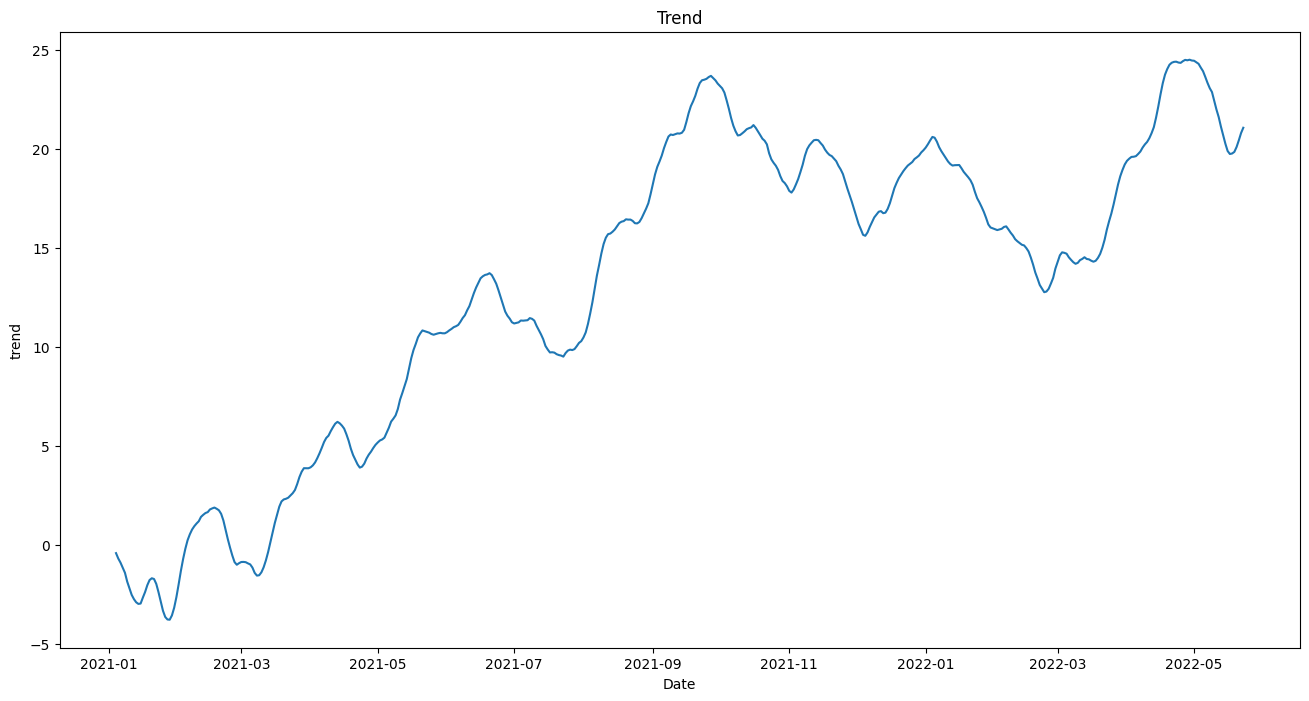

In [11]:
plt.figure(figsize=(16,8))
sns.lineplot(sd.trend)
plt.title('Trend')
plt.show()

### Seasonality

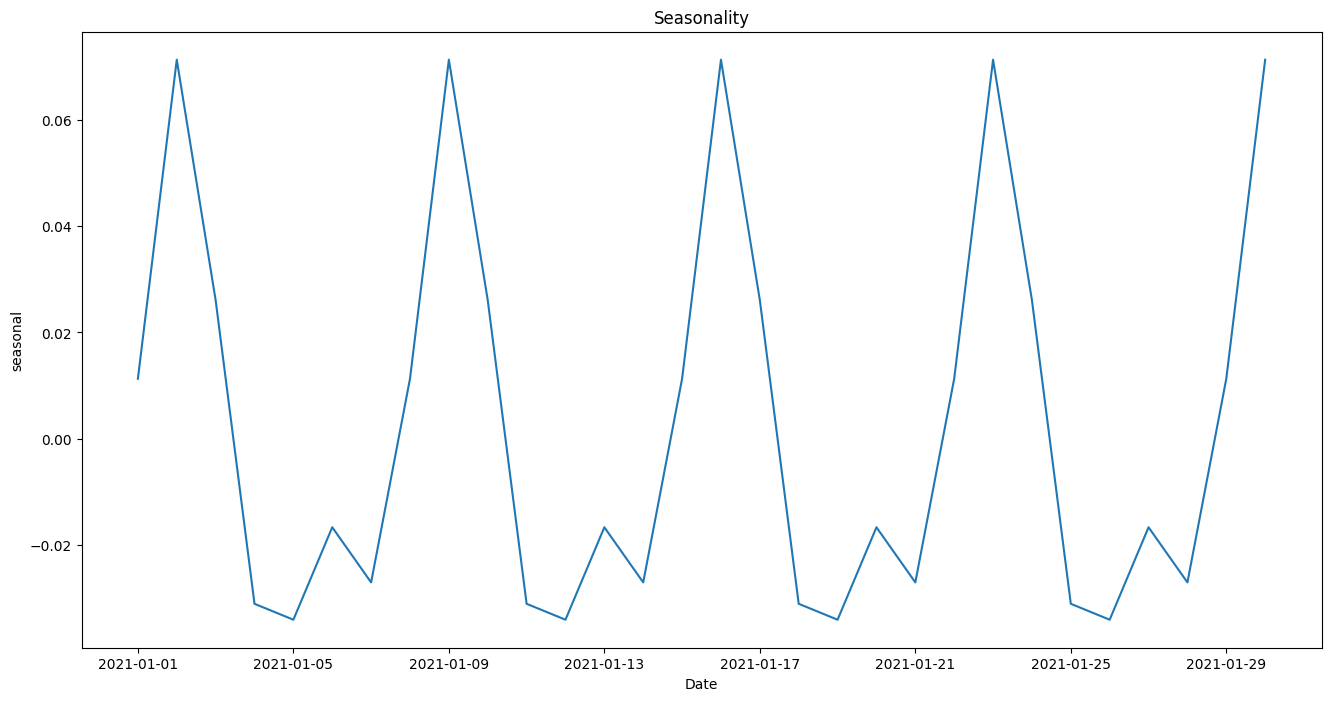

In [12]:
plt.figure(figsize=(16,8))
sns.lineplot(sd.seasonal[:30])
plt.title('Seasonality')
plt.show()

### Residuals

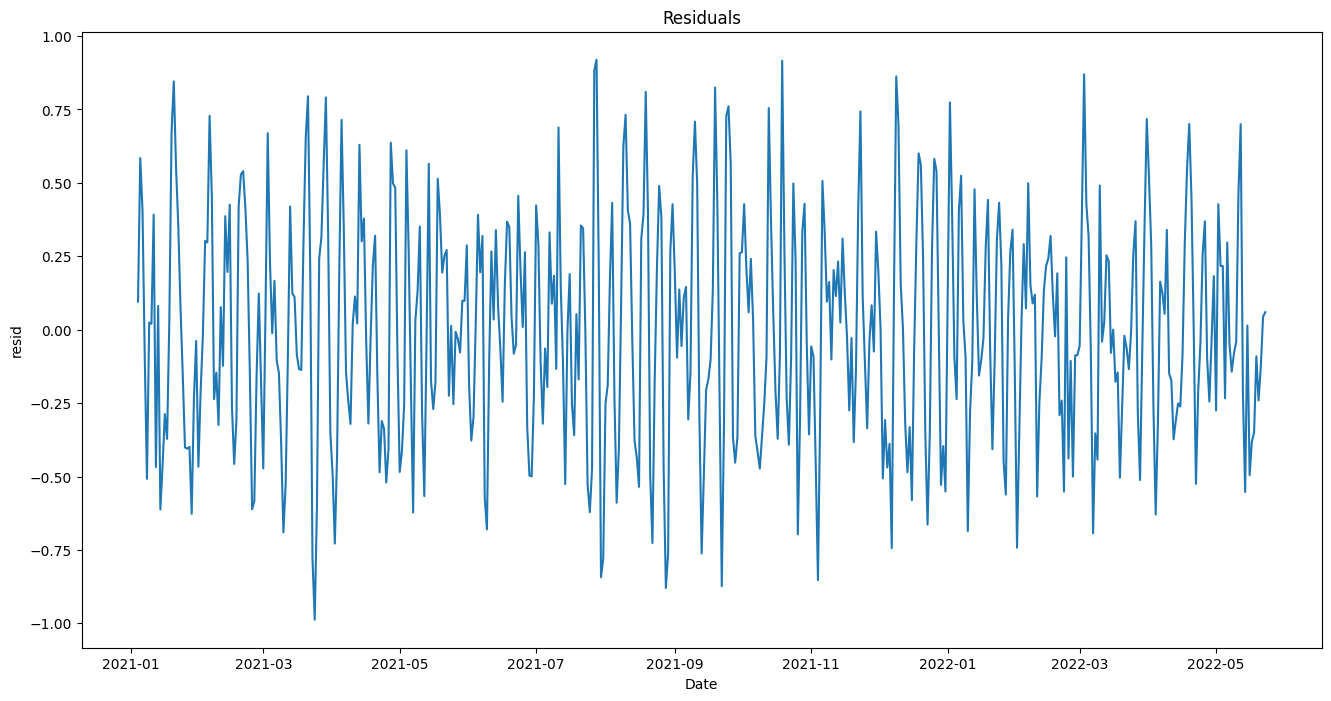

In [13]:
plt.figure(figsize=(16,8))
sns.lineplot(sd.resid)
plt.title('Residuals')
plt.show()

#### Stationarity

In [14]:
# import numpy for data manipulation
import numpy as np

x = sd.resid[~np.isnan(sd.resid)]
x

Date
2021-01-04    0.095590
2021-01-05    0.584582
2021-01-06    0.408334
2021-01-07   -0.087556
2021-01-08   -0.508117
                ...   
2022-05-19   -0.090392
2022-05-20   -0.240576
2022-05-21   -0.127007
2022-05-22    0.044174
2022-05-23    0.059640
Name: resid, Length: 505, dtype: float64

In [15]:
adf_result = adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print('ADF Statistic: %f' % adf_result[0])
print('Critical Value: %f' % adf_result[4]['5%'])
print('\np-value: %f' % adf_result[1])
print('Significance Level: 0.05')

ADF Statistic: -10.171273
Critical Value: -2.867420

p-value: 0.000000
Significance Level: 0.05


The ADF Statistic for the residuals is more negative than the Critical Value. The p-value is also less than the significance level of 0.05. For these reasons, we can reject the null hypothesis, i.e., the residuals are stationary.

## Autocorrelation Function

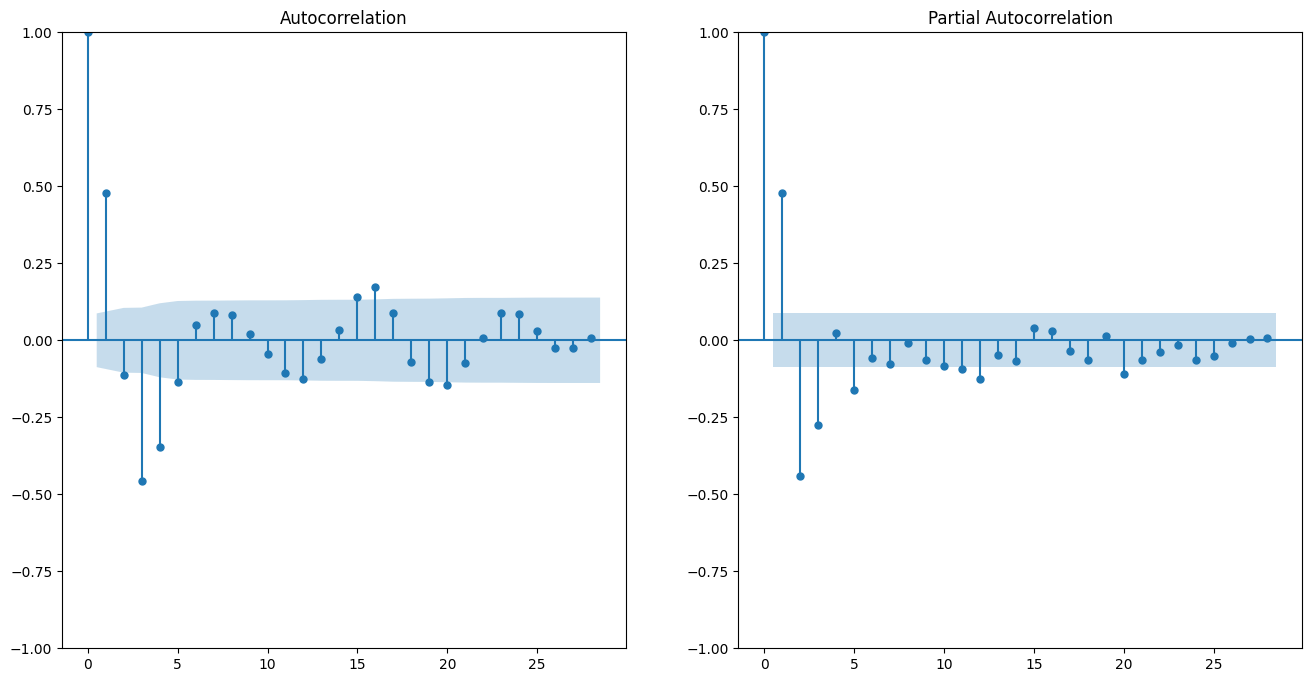

In [16]:
# use statsmodels to calculate the autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
plot_acf(sd.resid.dropna(), ax=ax1)
plot_pacf(sd.resid.dropna(), ax=ax2)
plt.show()

## Spectral Density

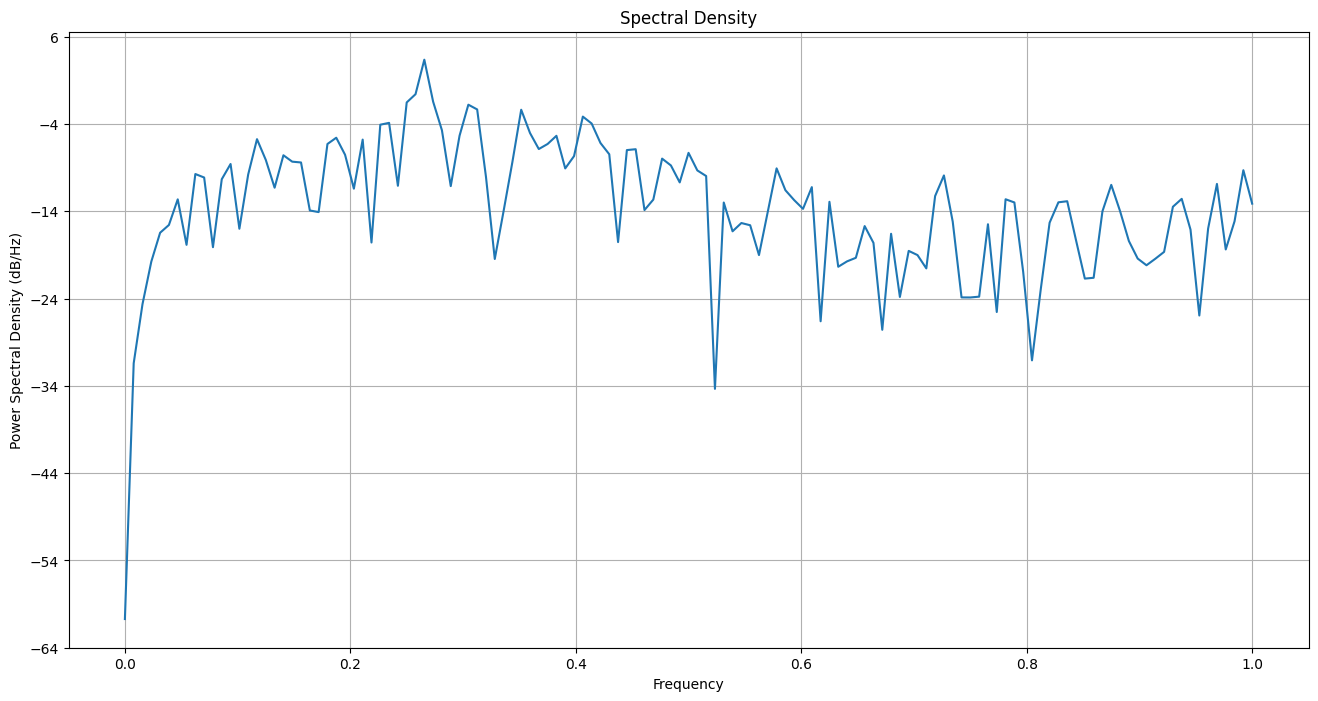

In [17]:
plt.figure(figsize=(16,8))
plt.psd(sd.resid.dropna())
plt.title('Spectral Density')
plt.show()

## Model Selection

In [18]:
# install pmdarima
# !pip install pmdarima

In [19]:
# use pmdarima to select appropriate ARIMA model
from pmdarima.arima import AutoARIMA

arima = AutoARIMA(seasonal=False)
arima.fit(sd.trend.dropna())
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  505
Model:               SARIMAX(4, 1, 3)   Log Likelihood                 572.656
Date:                Sun, 25 Jun 2023   AIC                          -1127.313
Time:                        23:12:32   BIC                          -1089.309
Sample:                    01-04-2021   HQIC                         -1112.405
                         - 05-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.004      0.478      0.633      -0.006       0.009
ar.L1          1.3719      0.144      9.527      0.000       1.090       1.654
ar.L2         -0.8566      0.123     -6.965      0.000      -1.098      -0.616
ar.L3          0.8194      0.085      9.641      0.000       0.653       0.986
ar.L4         -0.4437      0.065     -6.859      0.000      -0.570      -0.317
ma.L1         -0.1395      0.156     -0.894      0.371      -0.445       0.166
ma.L2          0.7335      0.069     10.704      0.000       0.599       0.868
ma.L3         -0.5499      0.145     -3.791      0.000      -0.834      -0.266
sigma2         0.0060      0.000     15.111      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.79   Prob(JB):                         0.84
Heteroskedasticity (H):               0.96   Skew:                             0.00
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Validation

In [20]:
# use pmdarima and validate model with test split
from pmdarima.metrics import smape

y_pred = arima.predict(n_periods=len(test))
smape(test, y_pred)

33.88046856314744

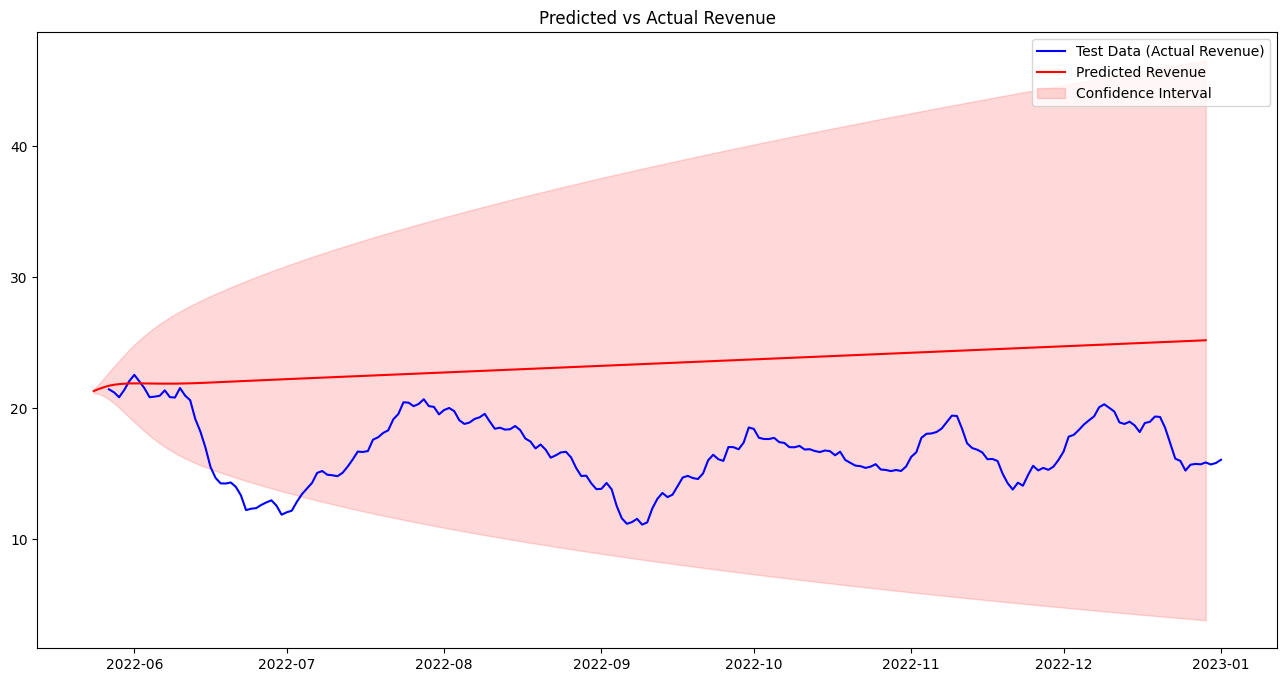

In [21]:
fig = plt.figure(figsize=(16,8))
plt.plot(test.Revenue, color='blue', label='Test Data (Actual Revenue)')
plt.plot(y_pred, color='red', label='Predicted Revenue')
plt.title('Predicted vs Actual Revenue')

# add confidence interval to plot
confidence = arima.predict(n_periods=len(test), return_conf_int=True)[1]
plt.fill_between(y_pred.index,
                     confidence[:, 0], confidence[:, 1],
                     alpha=0.15, color='red',
                     label="Confidence Interval")

plt.legend()
plt.show()

## Forecast

In [22]:
# update model with observed values
sd = seasonal_decompose(test, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
arima.update(sd.trend)

ARIMA(order=(4, 1, 3), scoring_args={}, suppress_warnings=True)

In [23]:
dti_f = pd.date_range("2023-01-02", periods=120, freq="D")
revenue_f = arima.predict(n_periods=120)
data = {'Date':dti_f, 'Revenue':revenue_f}

forecast = pd.DataFrame(data)
forecast.head(5)

,Date,Revenue
0,2023-01-02,16.583638
1,2023-01-03,16.768735
2,2023-01-04,16.943575
3,2023-01-05,17.090914
4,2023-01-06,17.211640


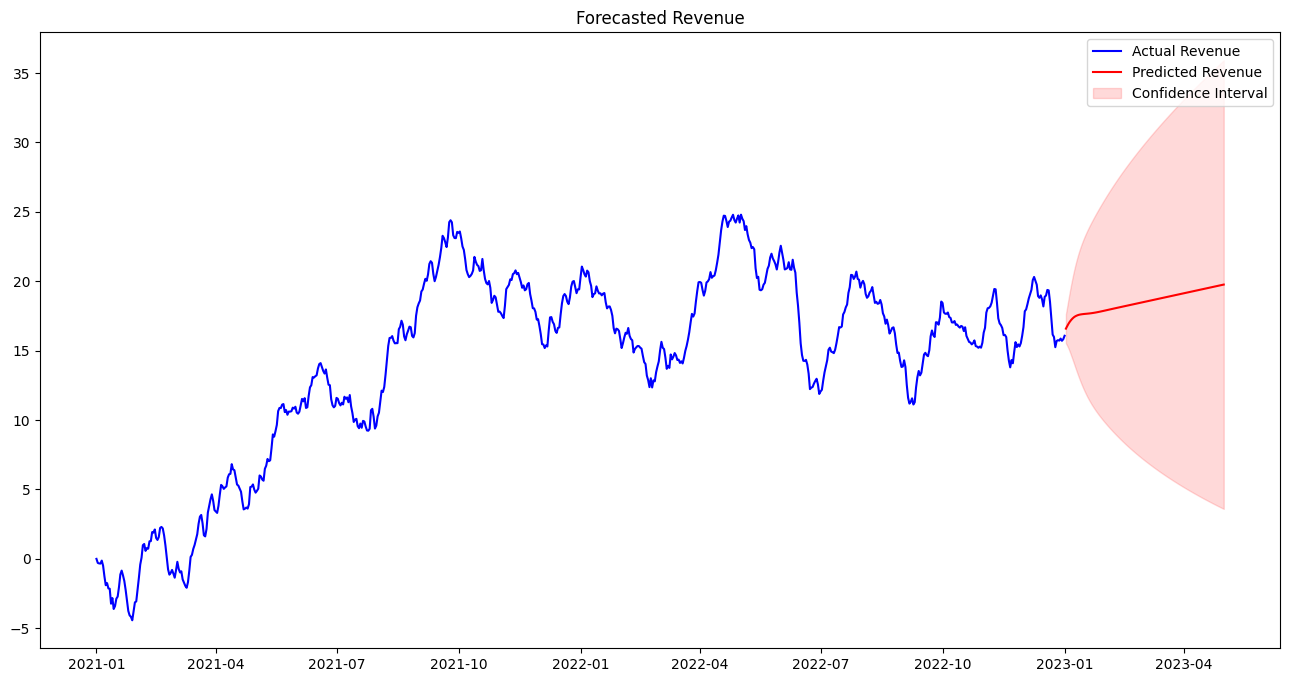

In [24]:
fig = plt.figure(figsize=(16,8))
plt.plot(df.Date, df.Revenue, color='blue', label='Actual Revenue')
plt.plot(forecast.Date, forecast.Revenue, color='red', label='Predicted Revenue')
plt.title('Forecasted Revenue')

# add confidence interval to plot
confidence = arima.predict(n_periods=120, return_conf_int=True)[1]
plt.fill_between(forecast.Date,
                     confidence[:, 0], confidence[:, 1],
                     alpha=0.15, color='red',
                     label="Confidence Interval")

plt.legend()
plt.show()

## Output

In [25]:
forecast.to_csv('output/forecast.csv', index=0)

# Part V: Data Summary and Implications

E.  Summarize your findings and assumptions by doing the following:

1. Discuss the results of your data analysis, including the following points:

•   the prediction interval of the forecast

3.  Recommend a course of action based on your results.

## Results

### Model Selection

The pmdarima library was used to select an appropriate ARIMA model using the AutoARIMA() function. This function chose the optimal ARIMA model by performing stepwise selection of variables that yielded the lowest Akaike information criterion (AIC) value. The result of this stepwise selection was a SARIMAX( 4, 1, 3) model with an AIC of -1127.313.

### Prediction Interval

### Forecast Length

The data was split 70/30 to create the train and test partitions. Because 30% of 731 (the number of records in the time series) is approximately 219, the forecast of the validation was 219 days long. Refer to the figure "Predicted vs Actual Revenue" for more.

Recall that the goal of this analysis was to predict three months of revenue growth for WGU Medical, specifically for Q1 2024. For this reason, the forecasted revenue growth was 120 days long. Refer to the figure "Forecasted Revenue" for more.

## Evaluation

The model was evaluated against the test split, which contained the last 220 records of the time series. The error metric used to evaluate the model was Symmetric Mean Absolute Percentage Error (SMAPE), and this metric was calculated using the smape() function from the pmdarima library. The SMAPE of the model was calculated at approximately 33.88%.

## Recommendation

# Part VI: Reporting

G.  Cite the web sources you used to acquire third-party code to support the application.

H.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.